In [105]:
import numpy as np
from scipy.stats import beta as bt
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import genfromtxt
plt.style.use('ggplot')
np.random.seed(42)

In [80]:
# epsilon-greedy
def eps_greedy(t_len, k_len, arms, inits, eps=0.1):
    culm_chosen = []
    
    alpha = [inits[0] for k in range(k_len)]
    beta = [inits[1] for k in range(k_len)]

    for t in range(t_len):
        
        # Calculate mean of bernoulli distribution
        empirical_mean=[alpha[k]/(alpha[k]+beta[k]) for k in range(k_len)]
        
        if np.random.rand() > eps:
            # exploit
            choice = np.argmax(empirical_mean)
        else:
            # explore
            choice = np.random.randint(0,k_len)
        
        # observe reward
        r = np.random.random()<arms[choice]
        
        # update state
        alpha[choice] += r
        beta[choice]+= 1-r
        
        # Append choice (for regret metric)
        culm_chosen.append(choice)
        
    return alpha,beta,culm_chosen

In [75]:
# Thompson Sampling
def Thompson(t_len, k_len, arms, priors):
    culm_chosen = []
    alpha = [priors[0] for k in range(k_len)]
    beta = [priors[1] for k in range(k_len)]
    for t in range(t_len):
        samples = [np.random.beta(alpha[k],beta[k]) for k in range(k_len)] # Collect samples
        best = np.argmax(samples) # Choose best
        r = np.random.random()<arms[best] # observe r_t (reward and for some reason 'True' counts as the value 1)
        # Update the state of the winning arm 
        alpha[best] += r
        beta[best] += 1-r
        # Append best
        culm_chosen.append(best)
    return alpha,beta,culm_chosen

# Plot posterior arm choices
def plot_res(a,b, t_len):
    x=np.linspace(0,1,1000)
    for  i in range(2):
        y = bt(a[i], b[i])
        plt.plot(x,y.pdf(x),  label=f'Posterior: Arm {i+1}, prob {arms[i]}')
    plt.title(f'T={t_len} rounds')
    plt.xlabel('Prob.')
    plt.legend()
    plt.show()

In [147]:
# UCB-Bayes
def BayesUCB(t_len, k_len, arms, priors, a_quantile=0.05):
    c=norm.ppf(1-a_quantile/2) # stds. as uppper confidence bound
    alpha = [priors[0] for k in range(k_len)]
    beta = [priors[1] for k in range(k_len)]
    culm_chosen = []
    for t in range(t_len):
        arm_probs = [alpha[k]/(alpha[k]+beta[k])+(c*bt(alpha[k],beta[k]).std()) for k in range(k_len)] # Perform bayes UCB with beta prior
        best = np.argmax(arm_probs) # Choose best
        r = np.random.random()<arms[best] # observe r_t (reward and for some reason 'True' counts as the value 1)
        # Update the state of the winning arm 
        alpha[best] += r
        beta[best] += 1-r
        # Append best
        culm_chosen.append(best)
    return alpha,beta,culm_chosen

In [97]:
# regret
def get_regret(arms, culm_chosen, t_len):
    # Keep empty list to update
    regret=[]
    # Range over length of T
    for T in range(1,t_len+1):
        # Iterate over arms (i know the best arm goes to 0 but i thought id generalise it anyway)
        armval = []
        for idx, arm in enumerate(arms):
            # use the regret rule from notes, take mean of the indicator choices up to the round T
            armval.append((arms[np.argmax(arms)]-arm)*(np.mean([culm_chosen[i]==idx for i in range(0,T)])))
        # Add arm 1 and arm 2 values (i know this is pointless since the best arm is 0 so only counts for non optimal arm)
        regret.append(armval[0]+armval[1])
    return regret

# To plot regrets
def plot_reg(regrets,names,t_len):
    for idx, regret in enumerate(regrets):
        plt.plot(np.cumsum(regret), label='regret {}'.format(names[idx]))
    plt.plot(np.linspace(1,t_len), np.log(np.linspace(1,t_len)), label='log', color='orange')
    plt.legend()
    plt.title(f'Regret T={t_len}')
    plt.show()    


In [177]:
# Simulation study
sims=100
eps_greedy_sims = []
thompson_sims = []
bucb_sims = []
t_len=10000
arms = [0.5, 0.55]
prior=[1,1]
for s in range(sims):
    print('Simulation {}:'.format(s))
    alpha_eps,beta_eps,c_eps=eps_greedy(t_len,2,arms, prior)
    regret_eps=get_regret(arms, c_eps, t_len)
    eps_greedy_sims.append(regret_eps) # There definitely exists a more efficient way to do this
    print('epsilon_greedy done')
    
    alpha_thomp,beta_thomp,c_thomp=Thompson(t_len,2,arms, prior)
    regret_thomp=get_regret(arms, c_thomp, t_len)
    thompson_sims.append(regret_thomp) 
    print('thompson done')
    
    alpha_bucb, beta_bucb, c_bucb = BayesUCB(t_len,2,arms,prior)
    regret_bucb=get_regret(arms, c_bucb, t_len)
    bucb_sims.append(regret_bucb)
    print('Bayes-UCB done')

Simulation 0:
epsilon_greedy done
thompson done
Bayes-UCB done
Simulation 1:
epsilon_greedy done


KeyboardInterrupt: 

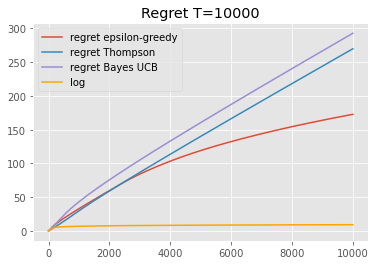

In [176]:
eps_greedy_avg=np.mean(eps_greedy_sims,axis=0)
thompson_avg=np.mean(thompson_sims,axis=0)
bucb_avg=np.mean(bucb_sims,axis=0)
plot_reg([eps_greedy_avg,thompson_avg,bucb_avg], ['epsilon-greedy', 'Thompson', 'Bayes UCB'],t_len)